In [7]:
import pandas as pd
import numpy as np
import datetime as dt
import os, json
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.tree import export_graphviz 
import graphviz

from sklearn.metrics import confusion_matrix
df=pd.DataFrame()
data=pd.DataFrame()

In [8]:
#func that reads the ''category'' column (from JSON format)
def CustomParser1(df):
    j1 = json.loads(df)
    return j1

This part loads as many files as instructed

In [9]:
def load_files (n):
    df=pd.DataFrame()
    read_df=pd.DataFrame()
    a=["%03d" % x for x in range(n)]
    for filenum in a:
        filename='Data/Kickstarter'+filenum+'.csv'
        read_df=pd.read_csv(filename,converters={'category':CustomParser1},header=0)
        df=pd.concat([df,read_df],ignore_index=True)
        
    df.info()
    return df
Filesnum=input('How many file should I load? 1..54  ')
df=load_files (int(Filesnum))
df.to_csv('data/jointfile.csv')

How many file should I load? 1..54  2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7630 entries, 0 to 7629
Data columns (total 37 columns):
backers_count               7630 non-null int64
blurb                       7630 non-null object
category                    7630 non-null object
converted_pledged_amount    7630 non-null int64
country                     7630 non-null object
created_at                  7630 non-null int64
creator                     7630 non-null object
currency                    7630 non-null object
currency_symbol             7630 non-null object
currency_trailing_code      7630 non-null bool
current_currency            7630 non-null object
deadline                    7630 non-null int64
disable_communication       7630 non-null bool
friends                     4 non-null object
fx_rate                     7630 non-null float64
goal                        7630 non-null float64
id                          7630 non-null int64
is_backing                  4 no

In [10]:
# df=pd.read_csv('Data/Kickstarter.csv',converters={'category':CustomParser1},header=0)
#make differnt columns out of ''category'' format
df[sorted(df['category'][0].keys(),reverse=False)] = df['category'].apply(pd.Series) 
df1=df[['category','color','parent_id','urls','id','name','position']]
df['category.parent_id']=df1['position']
df['category.id']=df1['color']
df['category.position']=df1['parent_id']
df['category.name']=df1['id']
df['category.slug']=df1['name']
#split ''slug'' and leaves just the main category name
df['category.slug']=df['category.slug'].apply(lambda x: x.split('/'))
df['category.slug']=df['category.slug'].apply(lambda x: x.pop(0))
df[['category','category.parent_id','category.id','category.name','category.position','category.slug']][:1]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7630 entries, 0 to 7629
Data columns (total 45 columns):
backers_count               7630 non-null int64
blurb                       7630 non-null object
category                    7630 non-null object
converted_pledged_amount    7630 non-null int64
country                     7630 non-null object
created_at                  7630 non-null int64
creator                     7630 non-null object
currency                    7630 non-null object
currency_symbol             7630 non-null object
currency_trailing_code      7630 non-null bool
current_currency            7630 non-null object
deadline                    7630 non-null int64
disable_communication       7630 non-null bool
friends                     4 non-null object
fx_rate                     7630 non-null float64
goal                        7630 non-null float64
id                          7630 non-null object
is_backing                  4 non-null object
is_starrable           

In [11]:
# func that reads the ''creator'' column (from JSON format).
#some of the cells cause problems 
    #for exemple- the cell JSON format include double apostrophes in nicknames like "Elad "Superman" Toister" confused it.

def CustomParser2(df2):
    try:
        j2 = json.loads(df2)
        return j2
    except: #the func pass all the errored rows and return 0 to the "creator" columnn. 
        return 0
    pass
            
df2=pd.read_csv('data/jointfile.csv',converters={'creator':CustomParser2},header=0)
#count and collect all the droped rows- so we can know the "cost" of te dropping (and maybe i will succed to solve it in the future)
droped=df2.loc[df2['creator']==0,['creator']]
df2=df2.loc[df2['creator']!=0]
drop_list=list(droped.index)
#df['creator'].iloc[drop_list]=df['creator'].iloc[drop_list].apply(lambda x: x.replace(' ',',')) is a start of a solution
df=df.drop(index=drop_list)
print('droped rows:',len(drop_list))
print (len(df))
print (len(df2))


droped rows: 10
7620
7620


In [12]:
# 2 func that make diffent columns out of "creator" column (the auto func i used before don't works here. i did it manually)
df2['creator_name']=df2['creator'].apply(lambda x: x['name'])
df2['creator_id']=df2['creator'].apply(lambda x: x['id'])
#"inject" it back to the original df
df['creator_name']=df2['creator_name']
df['creator_id']=df2['creator_id']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7620 entries, 0 to 7629
Data columns (total 47 columns):
backers_count               7620 non-null int64
blurb                       7620 non-null object
category                    7620 non-null object
converted_pledged_amount    7620 non-null int64
country                     7620 non-null object
created_at                  7620 non-null int64
creator                     7620 non-null object
currency                    7620 non-null object
currency_symbol             7620 non-null object
currency_trailing_code      7620 non-null bool
current_currency            7620 non-null object
deadline                    7620 non-null int64
disable_communication       7620 non-null bool
friends                     4 non-null object
fx_rate                     7620 non-null float64
goal                        7620 non-null float64
id                          7620 non-null object
is_backing                  4 non-null object
is_starrable           

In [13]:
#cleaning func
def clean(df):
    data = df.copy()
    #this is important beacuse this is the part we decide  which columns entered the data set.
    #the main structure is like in the exemple but i manipulate and add some additional columns i think we need to include(*marked) . 
    selected_cols = ['creator_name', #*
                     'creator_id', #*
                     'backers_count',
                     'blurb',
                     'is_starred', #*
                     'category.id', #*
                     'category.name',
                     'category.parent_id',
                     'category.slug',
                     'country',
                     'created_at',
                     'currency',  
                     'deadline',
                     'goal',
                     'launched_at',
                     'staff_pick',
                     'state',
                     'usd_pledged',
                     'usd_type']
    data = data[selected_cols]
    data['is_starred']=data['is_starred'].replace({1: True , None: False})
    data = data.dropna()
    successful = data['state'] == "successful"
    failed = data['state'] == "failed"
    cancelled = data['state'] == "cancelled"
    suspended = data['state'] == "suspended"
    data = data.loc[failed | successful | cancelled | suspended]
    num_cols = ['usd_pledged',
                'deadline',
                'created_at',
                'launched_at']
    data[num_cols] = data[num_cols].apply(pd.to_numeric, errors='coerce')
    data['created_at'] = pd.to_datetime(data['created_at'],unit='s')
    data['launched_at'] = pd.to_datetime(data['launched_at'],unit='s')
    data['deadline'] = pd.to_datetime(data['deadline'],unit='s')
    return data

data = clean(df)


In [14]:
def engineer_features(data):
    #make state 1 or 0
    data['state'].replace('suspended','failed',inplace=True)   
    data['state_num'] = data['state'].apply(lambda x: 1 if x=='successful' else 0)
    #time to reletive time
    data['launched_at_hr'] = data['launched_at'].apply(lambda x: x.hour) + 1
    data['launched_at_day_in_week'] = data['launched_at'].apply(lambda x: x.dayofweek + 1)
    data['launched_at_day_in_month'] = data['launched_at'].apply(lambda x: x.day ) #Elad's comment
    data['launched_at_mo'] = data['launched_at'].apply(lambda x: x.month)
    data['launched_at_yr'] = data['launched_at'].apply(lambda x: x.year)
    data['deadline_hr'] = data['deadline'].apply(lambda x: x.hour) + 1
    data['deadline_day_in_week'] = data['deadline'].apply(lambda x: x.dayofweek + 1) 
    data['deadline_day_in_month'] = data['deadline'].apply(lambda x: x.day ) #Elad's comment
    data['deadline_mo'] = data['deadline'].apply(lambda x: x.month)
    data['deadline_yr'] = data['deadline'].apply(lambda x: x.year)
    data['created_at_hr'] = data['created_at'].apply(lambda x: x.hour) + 1
    data['created_at_day_in_week'] = data['created_at'].apply(lambda x: x.dayofweek + 1) 
    data['created_at_day_in_month'] = data['created_at'].apply(lambda x: x.day )  #Elad's comment
    data['created_at_mo'] = data['created_at'].apply(lambda x: x.month)
    data['created_at_yr'] = data['created_at'].apply(lambda x: x.year)
    data['count'] = 1
    data['success'] = (data['state'] == 'successful')
    data['launched-created'] = (data.launched_at - data.created_at).dt.components.days
    data['deadline-launched'] = (data.deadline - data.launched_at).dt.components.days
    data=data.drop(['launched_at','created_at','deadline'],axis=1) #drop original time col
    data['pledge_perc']=data['usd_pledged']/data['goal']*100
   
    return data
data = engineer_features(data)
data.info()
data.to_csv('Data/data.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6341 entries, 0 to 7629
Data columns (total 37 columns):
creator_name                6341 non-null object
creator_id                  6341 non-null int64
backers_count               6341 non-null int64
blurb                       6341 non-null object
is_starred                  6341 non-null bool
category.id                 6341 non-null int64
category.name               6341 non-null object
category.parent_id          6341 non-null float64
category.slug               6341 non-null object
country                     6341 non-null object
currency                    6341 non-null object
goal                        6341 non-null float64
staff_pick                  6341 non-null bool
state                       6341 non-null object
usd_pledged                 6341 non-null float64
usd_type                    6341 non-null object
state_num                   6341 non-null int64
launched_at_hr              6341 non-null int64
launched_at_day_i

In [15]:
data.to_csv('data/jointfile.csv')

In [16]:
data=pd.read_csv('data/jointfile.csv')

In [17]:
corr_df=data.corr()
cor_st=corr_df.loc['state_num']
print(cor_st.nsmallest())
print(cor_st.nlargest())

category.id      -0.344122
deadline_yr      -0.208537
created_at_yr    -0.207720
launched_at_yr   -0.205550
goal             -0.092682
Name: state_num, dtype: float64
state_num        1.000000
success          1.000000
staff_pick       0.273477
backers_count    0.151934
usd_pledged      0.146663
Name: state_num, dtype: float64


# Cut edge

In [18]:
numrical=[
 'goal',
 'usd_pledged',
 'launched-created',
 'deadline-launched',
 'pledge_perc']


In [19]:
stats.normaltest(data['goal'])

NormaltestResult(statistic=17373.296692026404, pvalue=0.0)

C:\Users\elad.toister\AppData\Local\Continuum\anaconda3-1\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


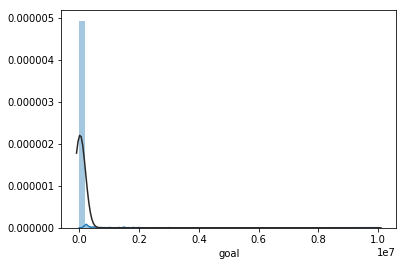

In [20]:
data['goal'].describe()
sns.distplot(data["goal"], fit=norm)

C:\Users\elad.toister\AppData\Local\Continuum\anaconda3-1\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


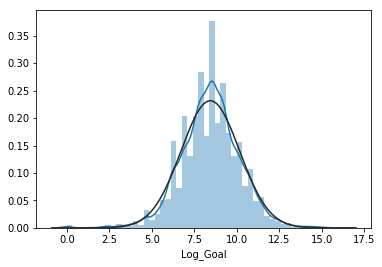

In [21]:
#בהמשך נצטרך לפצל את המידע
goal_highst = data[data["goal"] > 4500] 
goal_lowsat = data[data["goal"] <= 4500] 
log_goal = np.log(data["goal"]) #This data change proves best to fit goal into normal dist.
sqrt_goal = np.sqrt(data["goal"]) 
#sns.distplot(df_highsat[["goal"]], fit=norm)
#sns.distplot(df_lowsat[["goal"]], fit=norm)
sns.distplot(log_goal,bins=None, fit=norm,axlabel='Log_Goal')

#sns.distplot(sqrt_goal, fit=norm)

In [22]:
#Following investigation update the dataframe for log goal
data['goal']=np.log(data['goal'])

C:\Users\elad.toister\AppData\Local\Continuum\anaconda3-1\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


count    6341.000000
mean       44.367292
std       115.810016
min         0.000000
25%         2.000000
50%        10.000000
75%        35.000000
max      1909.000000
Name: launched-created, dtype: float64

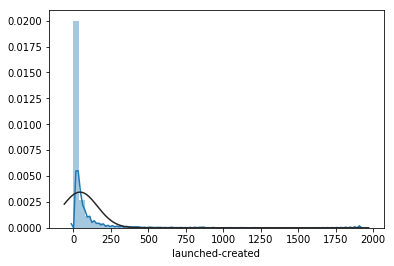

In [23]:
sns.distplot(data["launched-created"], fit=norm)
data["launched-created"].describe()

C:\Users\elad.toister\AppData\Local\Continuum\anaconda3-1\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\elad.toister\AppData\Local\Continuum\anaconda3-1\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\elad.toister\AppData\Local\Continuum\anaconda3-1\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


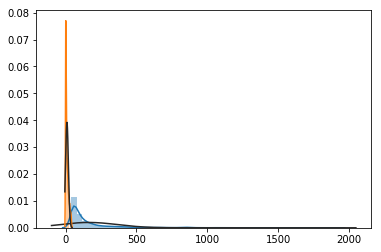

In [24]:
#לחלק שונה בין דגימה של תיאטרון/קולנוע ולא
lu_highst = data[data["launched-created"] >40] 
lu_lowest = data[data["launched-created"] <= 40] 
log_lu = np.log(data["launched-created"])
sqrt_lu = np.sqrt(data["launched-created"])
sns.distplot(lu_highst[["launched-created"]], fit=norm, bins=50)
sns.distplot(lu_lowest[["launched-created"]], fit=norm, bins=50)
#sns.distplot(log_lu, fit=norm)
#sns.distplot(sqrt_lu, fit=norm)

C:\Users\elad.toister\AppData\Local\Continuum\anaconda3-1\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


count    6341.000000
mean       33.478158
std        12.655221
min         1.000000
25%        29.000000
50%        30.000000
75%        35.000000
max        91.000000
Name: deadline-launched, dtype: float64

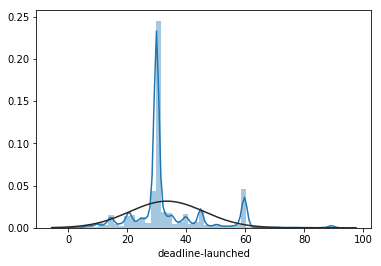

In [25]:
sns.distplot(data["deadline-launched"], fit=norm)
data["deadline-launched"].describe()

C:\Users\elad.toister\AppData\Local\Continuum\anaconda3-1\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


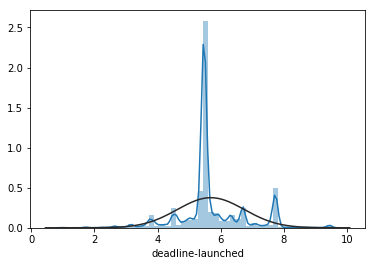

In [26]:
de_highst = data[data["deadline-launched"] >50] 
de_lowest = data[data["deadline-launched"] <= 50]
#צריך בהמשך לעשות LOG על הגבוה והנמוך בנפרד
log_de = np.log(data["deadline-launched"])
sqrt_de = np.sqrt(data["deadline-launched"])
#sns.distplot(de_highst[["deadline-launched"]], fit=norm)
#sns.distplot(de_lowest[["deadline-launched"]], fit=norm)
#sns.distplot(log_de, fit=norm)
sns.distplot(sqrt_de, fit=norm) 

In [27]:
#בנתיים נעשה רק SQRT (צריך לבדוק יעילות)
data["deadline-launched"]=np.log(data["deadline-launched"])

## Data visualization

In [ ]:
from seaborn import set
plt.rcParams['figure.figsize']=(20,20)
set(font_scale=2)
b=sns.countplot(x='category.slug', hue='success',data=data)
b.set_xlabel("Categories",fontsize=18)
b.set_ylabel("Count",fontsize=18)
b.tick_params(labelsize=14)

In [ ]:
PP=np.clip(data['pledge_perc'], 0, 500)
fig=PP.hist(bins = 200, figsize = (20,15),color='gold')
fig.set_xlabel("% of Capital raised from initial goal",fontsize=18,color='b')
fig.set_ylabel("Count",fontsize=18,color='b')


In [ ]:
corr_matrix = data.corr()
corr_matrix["success"].sort_values()

In [ ]:
sns.heatmap(corr_matrix[(corr_matrix<1) & ((corr_matrix >= 0.2) | (corr_matrix <= -0.2)) ] )

In [ ]:
plt.scatter(x='category.slug', y='usd_pledged', data=data, alpha=0.5, color='r')
plt.ylabel("USD Pledged",fontsize=18)

In [ ]:
sns.factorplot(x='category.slug', y='goal', hue='state_num', kind='bar', data=data, size=15)
locs, labels = plt.xticks();
plt.setp(labels, rotation=90);
plt.title('Range of goal ($) among successful and failed projects')
plt.gca().set_yscale("log", nonposy='clip');
#מראה את הצלחת הפרויקטים לפי סכום היעד לגיוס- רואים שבגדול פרויקטים שנכשלו ביקשו יותר מדי. מצד שני רואים (טבלה הבאה) שפרויקטים שהצליחו לרב יגייסו 150%
#

In [ ]:
df_suc=data.loc[data['success']==True]
ax=sns.factorplot(x='category.slug', y='pledge_perc', kind='bar', data=data, size=15)
locs, labels = plt.xticks();
plt.setp(labels, rotation=90);
plt.title('Pledge % (log) Among Successful Projects')
plt.gca().set_yscale("log", nonposy='clip');
#מה אחוז הגיוס מתוך פריקטים שהצליחו. רואים שניתן לגייס ''פחות'' אבל בפועל יצא יותר

In [ ]:
print('Average pledge % per category')
df_suc.groupby('category.slug', as_index=False, sort=False)['pledge_perc'].mean()

In [ ]:
sns.factorplot(x='category.slug', y='launched-created', hue='state_num', kind='bar', data=data, size=15)
locs, labels = plt.xticks();
plt.setp(labels, rotation=90);
plt.title('Time difference between lunched and created [days]')
plt.gca().set_yscale("linear", nonposy='clip');
#כמעט תמיד עדיף להשיק אחרי שהקמפייין ''מתבשל'' קצת. חריגים הם הקולנוע והתיאטרון

In [ ]:
sns.factorplot(x='category.slug', y='deadline-launched', hue='state_num', kind='bar', data=data, size=7)
locs, labels = plt.xticks();
plt.setp(labels, rotation=90);
plt.title('Deadline-launched [Days]')
plt.gca().set_yscale("linear", nonposy='clip');
#נתון כנראה לא רלוונטי

#  Data set creation

In [28]:
data=pd.read_csv('data/jointfile.csv',header=0)

In [29]:
Dtree_Params=['goal','deadline-launched','launched-created','staff_pick','category.id']
train_df, test_df= train_test_split (data, test_size = 0.2, random_state=6)
Y_train = train_df["state_num"]
X_train = train_df[Dtree_Params]
Y_test=test_df["state_num"]
X_test=test_df[Dtree_Params]

##  Large Tree ML

In [ ]:

mod1_columns=[ 'is_starred', 'category.name', 'category.slug',
       'country', 'currency', 'goal', 'staff_pick', 'launched_at_hr',
       'launched_at_day_in_week', 'launched_at_day_in_month', 'launched_at_mo',
       'launched_at_yr', 'deadline_hr', 'deadline_day_in_week',
       'deadline_day_in_month', 'deadline_mo', 'deadline_yr', 'created_at_hr',
       'created_at_day_in_week', 'created_at_day_in_month', 'created_at_mo',
       'created_at_yr', 'launched-created',
       'deadline-launched','state_num']

dummies=['category.name', 'category.slug','country', 'currency']

mod1=data[mod1_columns]
mod1 = pd.get_dummies(mod1, columns=dummies) #mod1 will be the first df for the pridiction with spcific columns (maybe afterwords we will wont to add columns)
list(mod1.columns)

In [ ]:
print(len(mod1))
corr_df=mod1.corr()
#corr_df[corr_df['state_num']==1]
#corr_df[(corr_df<1) & ((corr_df >= 0.3) | (corr_df <= -0.3)) ]



In [ ]:
cor_st=corr_df.loc['state_num']
print(cor_st.nsmallest())
print(cor_st.nlargest())


In [ ]:
mod1_params= mod1.columns.drop('state_num')
mod1_params


In [ ]:
Dtree_Params=mod1_params
train_df, test_df= train_test_split (mod1, test_size = 0.2, random_state=6)
Y_train = train_df["state_num"]
X_train = train_df[Dtree_Params]
Y_test=test_df["state_num"]
X_test=test_df[Dtree_Params]
tree_clf = DecisionTreeClassifier (max_depth = 3)
tree_clf.fit (X_train, Y_train)

Decision Tree visualization

In [ ]:
from sklearn.tree import export_graphviz #In the cmd line type: conda install python-graphviz
import graphviz

dot_data = export_graphviz(tree_clf, out_file = None, 
                           feature_names = Dtree_Params, 
                           class_names = ["Succeed", "Fail" ],
                           rounded = True, filled=True, special_characters=True)
graph = graphviz.Source(dot_data) 
graph

In [ ]:
# Run the test set through the decision tree
Y2_test_Tree_predict = tree_clf.predict (X_test)  

#Test set conf matrix
conf_matrix_Testdata = confusion_matrix(Y_test, Y2_test_Tree_predict) 
conf_matrix_Testdata

In [ ]:
#Train set conf. matrix
conf_matrix_Traindata = confusion_matrix(Y_train, tree_clf.predict (X_train)) 
conf_matrix_Traindata

In [ ]:
from sklearn.metrics import precision_score, recall_score

print("The recall for the train set is ",recall_score(Y_train, tree_clf.predict (X_train)))
print("The recall for the test set tree is ",recall_score(Y_test, Y2_test_Tree_predict))
print("The precision for the train set tree is ",precision_score(Y_train, tree_clf.predict (X_train)))
print("The precision for the test tree is ",precision_score(Y_test, Y2_test_Tree_predict))

In [ ]:
Y_test_proba = tree_clf.predict_proba(X_test)
Y_test_proba[:,1]

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_true = Y_test, probas_pred = Y_test_proba[:,1])
print(" Precision = ", precisions, "\n", "Recalls = ", recalls, "\n", "Thresholds = ", thresholds)

## Precision plot graph 

In [ ]:
def plot_precision_recall_vs_threshold (precisions, recalls, thresholds, color = "k", label = None):
    plt.plot (thresholds, precisions[:-1], color+"--", label="Precision "+label)
    plt.plot (thresholds, recalls[:-1], color+"-", label="Recall "+label)
    plt.xlabel("Threshold")
    plt.legend(loc="upper right")
    plt.ylim([0,1])

In [ ]:
plot_precision_recall_vs_threshold( precisions, recalls, thresholds, color = "b", label="Full tree")
plt.legend(loc = "best")

## Roc Curve Plotting

In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
fpr, tpr, thresholds = roc_curve(Y_test, Y_test_proba[:,1])

In [ ]:
def plot_roc_curve (fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0,1], [0,1], "k--")
    plt.axis([0,1,0,1])
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    
plot_roc_curve (fpr, tpr, "Full tree")
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
print("AUC for random guess is:   ", 0.5 )
print("AUC for the Full tree is: ", roc_auc_score(Y_test, Y_test_proba[:,1]) )

## Random forest (RF)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators = 1000, max_depth = 2, n_jobs= -1)
rnd_clf.fit (X_train, Y_train)
y_pred_rf = rnd_clf.predict(X_test)

In [ ]:
confusion_matrix(Y_test, y_pred_rf)

In [ ]:
recall_score(Y_test, y_pred_rf)

In [ ]:
precision_score(Y_test, y_pred_rf)

In [ ]:
y_rf_proba = rnd_clf.predict_proba(X_test)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(Y_test, y_rf_proba[:,1])
plot_roc_curve (fpr, tpr, "Full tree")
plot_roc_curve (fpr_rf, tpr_rf, "Random Forest")
plt.legend(loc = "best")
plt.show()

In [ ]:
roc_auc_score(Y_test, y_rf_proba[:,1])

In [ ]:
feature_score = rnd_clf.feature_importances_
feature_score

In [ ]:
feature_names = list(X_train)
df_feature_score = pd.DataFrame(data=feature_names, columns=["feature"])
df_feature_score["score"]= feature_score
df_feature_score = df_feature_score.sort_values(by=['score'], ascending=False)
#df_feature_score.head()
df_feature_score_short=df_feature_score.drop(df_feature_score.index[12:])
df_feature_score_short

In [ ]:
sns.barplot(y="feature", x="score", data=df_feature_score_short)

## GBM

In [ ]:
from sklearn import ensemble

clf_gb = ensemble.GradientBoostingClassifier()
clf_gb.fit(X_train, Y_train)

In [ ]:
y_pred_gb = clf_gb.predict(X_test)

In [ ]:
confusion_matrix(Y_test, y_pred_gb)

In [ ]:
recall_score(Y_test, y_pred_gb)

In [ ]:
precision_score(Y_test, y_pred_gb)

In [ ]:
y_gb_proba = clf_gb.predict_proba(X_test)
fpr_gb, tpr_gb, thresholds_gb = roc_curve(Y_test, y_gb_proba[:,1])

y_rf_proba = rnd_clf.predict_proba(X_test)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(Y_test, y_rf_proba[:,1])
plot_roc_curve (fpr, tpr, "Full tree")
plot_roc_curve (fpr_rf, tpr_rf, "Random Forest")
plot_roc_curve (fpr_gb, tpr_gb, "gradient boosting")
plt.legend(loc = "best")
plt.show()

## Precision graph plots for all methods

In [ ]:
precisions_GB, recalls_GB, thresholds_GB = precision_recall_curve(y_true = Y_test, probas_pred = y_gb_proba[:,1])
precisions_RF, recalls_RF, thresholds_RF = precision_recall_curve(y_true = Y_test, probas_pred = y_rf_proba[:,1])
precisions, recalls, thresholds = precision_recall_curve(y_true = Y_test, probas_pred = Y_test_proba[:,1])

plt.plot (thresholds, precisions[:-1], "r"+"--", label="Precision Full Tree")
plt.plot (thresholds, recalls[:-1], "r"+"-", label="Recall Full Tree ")
plt.plot (thresholds_GB, precisions_GB[:-1], "b"+"--", label="Precision GB")
plt.plot (thresholds_GB, recalls_GB[:-1], "b"+"-", label="Recall GB")
plt.plot (thresholds_RF, precisions_RF[:-1], "c"+"--", label="Precision RF")
plt.plot (thresholds_RF, recalls_RF[:-1], "c"+"-", label="Recall RF")

plt.xlabel("Threshold")
plt.legend(loc="upper right")
plt.ylim([0,1])


## Linear Regression

In [30]:
# Linear Regression imports
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

from sklearn.metrics import mean_squared_error

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6341 entries, 0 to 6340
Data columns (total 38 columns):
Unnamed: 0                  6341 non-null int64
creator_name                6341 non-null object
creator_id                  6341 non-null int64
backers_count               6341 non-null int64
blurb                       6341 non-null object
is_starred                  6341 non-null bool
category.id                 6341 non-null int64
category.name               6341 non-null object
category.parent_id          6341 non-null float64
category.slug               6341 non-null object
country                     6341 non-null object
currency                    6341 non-null object
goal                        6341 non-null float64
staff_pick                  6341 non-null bool
state                       6341 non-null object
usd_pledged                 6341 non-null float64
usd_type                    6341 non-null object
state_num                   6341 non-null int64
launched_at_hr   

In [56]:
#define parameters for regression
y = data [['pledge_perc']]
X = data[['goal','deadline-launched','launched-created','category.id','staff_pick']]

In [57]:
#split to train and test
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.2, random_state=7)

In [58]:
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [59]:
print("predicted y = ", lin_reg.coef_, " * X + ", lin_reg.intercept_)

predicted y =  [[ -3.77711635e-04  -3.91086160e+01   4.81450516e+01  -3.67448390e+00
   -1.43321483e+03]]  * X +  [ 881.89849971]


In [60]:
y_test_pred_numeric = lin_reg.predict(X_test)

In [61]:
lin_reg.score(X_test, y_test)

-34.684195656735589

In [62]:
mean_squared_error(y_test, y_test_pred_numeric)

44047801.007128805

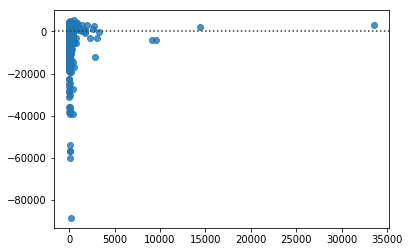

In [63]:
sns.residplot(y_test, y_test-y_test_pred_numeric )